# Индивидуальное задание по ML. Тема: Stacking (Insurance)

## Условие и кто выполнил

Цель - предсказать, продолжит ли клиент пользоваться своим аккаунтом или закроет его

Модель: XGBoost, Logistic Regression, CatBoost

Должно быть выполнено:

1. Исследовательский анализ данных (EDA)
2. Предварительная обработка данных
3. Построение и оценка моделей Logistic Regression, XGBoost и CatBoost.
4. Улучшение результатов с помощью стекинга указанных моделей.

Выполнил: студент группы 5030102/10201 Голузин Егор Константинович.

## Решение


### Краткая теоретическая справка

XGBoost - библиотека с открытым исходным кодом, предоставляющая оптимизированную быстродействующую реализацию метода машинного обучения под названием <<Градиентный бустинг>>. Основные концепции, заложенные в XGBoost:
1. Градиентный бустинг:
Каркас всего XGBoost, метод ансамблевого обучения, где слабые модели (обычно деревья решений) последовательно добавляются, чтобы минимизировать функцию потерь.
Каждое новое дерево исправляет ошибки предыдущего ансамбля, используя отрицательный градиент как целевую переменную.
2. Регуляризация:  
Претодвращает переобучение за счет контроля сложности моделей.
3. Скорость и поддержка параллелизма
4. Эффективная работа с памятью

Logistic Regression — это алгоритм машинного обучения, который используется для бинарной классификации, то есть для предсказания результатов, принимающих два значения, таких как «да/нет», «истина/ложь» или «0/1». 

Основные характеристики логистической регрессии:
1. Бинарная классификация: Логистическая регрессия используется для решения задач, где цель состоит в том, чтобы классифицировать объекты на две категории (например, "да" или "нет", "успех" или "неуспех")
2. Логистическая функция (сигмоида): Основу логистической регрессии составляет логистическая функция (или сигмоида), которая применяется к линейной комбинации входных признаков. Она преобразует любое реальное число в значение диапазона от 0 до 1, представляющее вероятность принадлежности к положительному классу
3. Функция потерь: Для обучения модели логистической регрессии используется функция потерь, обычно метод максимального правдоподобия. Это позволяет находить коэффициенты, которые наилучшим образом описывают данные

CatBoost — это библиотека для градиентного бустинга. Она предназначена для решения задач машинного обучения, таких как классификация и регрессия. CatBoost обладает несколькими ключевыми особенностями:
1. Поддержка категориальных признаков: CatBoost автоматически обрабатывает категориальные данные без необходимости их предварительного кодирования (например, one-hot encoding), что упрощает работу с данными
2. Устойчивость к переобучению: Алгоритм включает в себя различные техники регуляризации, что делает модель более устойчивой к переобучению и позволяет эффективно работать с небольшими наборами данных
3. Работа с пропущенными значениями: CatBoost может обрабатывать пропуски в данных, что устраняет необходимость предварительной обработки

Стекинг моделей - это метод ансамблирования, который комбинирует несколько алгоритмов для улучшения предсказательной способности. Он работает путем обучения мета-модели на выходах базовых моделей. В нашем случае, мы можем использовать логистическую регрессию, XGBoost и CatBoost как базовые модели, а мета-модель для объединения их выводов. 
Для начала мы обработаем данные, затем обучим наши модели и затем построим мета-модель на основе обученных моделей.

### Исследовательский анализ данных (EDA)

Для начала импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

`pandas` будет необходим для работы с табличными значениями, `numpy` - для удобства работы с матрицами и векторами, `seaborn` и `matplotlib` - для визуализации данных, `sklearn` - для разделения выборок и удобства вычисления метрик, и непосредственно `xgboost` - для самой модели градиентного бустинга.

Для начала загрузим наши данные и выведем общую информацию:

In [2]:
train_data = pd.read_csv('data.csv')

print('Information about train data: ')
print(train_data.head()) 
print(train_data.info()) 


Information about train data: 
   id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   0    Male   21                1         35.0                   0   
1   1    Male   43                1         28.0                   0   
2   2  Female   25                1         14.0                   1   
3   3  Female   35                1          1.0                   0   
4   4  Female   36                1         15.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0    1-2 Year            Yes         65101.0                 124.0      187   
1   > 2 Years            Yes         58911.0                  26.0      288   
2    < 1 Year             No         38043.0                 152.0      254   
3    1-2 Year            Yes          2630.0                 156.0       76   
4    1-2 Year             No         31951.0                 152.0      294   

   Response  
0         0  
1         1  
2         0  
3    

Отсутствуют NULL значения, поэтому можно не очищать датасет от этих значений. Переменная, которая нас интересует - это `Response`, то есть положительно отреагирует человек на предложение о страховании или нет, поэтому имеем задачу бинарной классификации. Посмотрим на распределение `Response`:

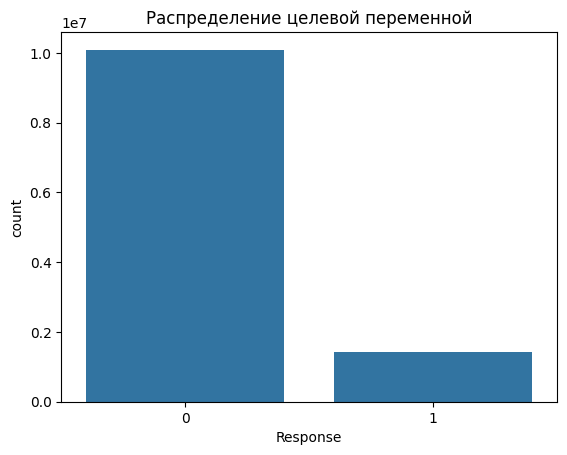

In [3]:
sns.countplot(x='Response', data=train_data)
plt.title('Распределение целевой переменной')
plt.show()

К сожалению, классы несбалансированны, поэтому при обучении модели мы должны это учесть.

Посмотрим на корреляцию `Response` с другими числовыми данными.

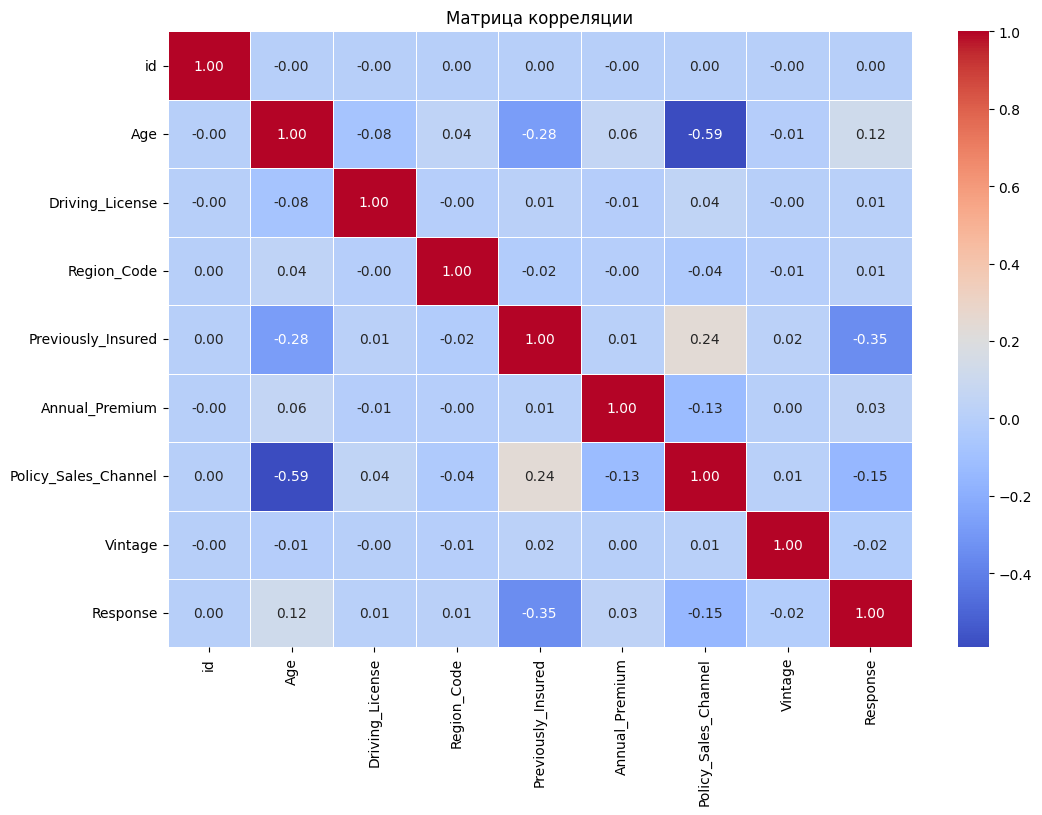

In [4]:
numeric_data = train_data.select_dtypes(include=['number'])

correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

Влиянет на `Response` только возраст отчасти, другие тендеции не прослеживаются

Разберемся с корреляцией категориальных данных, для этого предварительно закодируем их

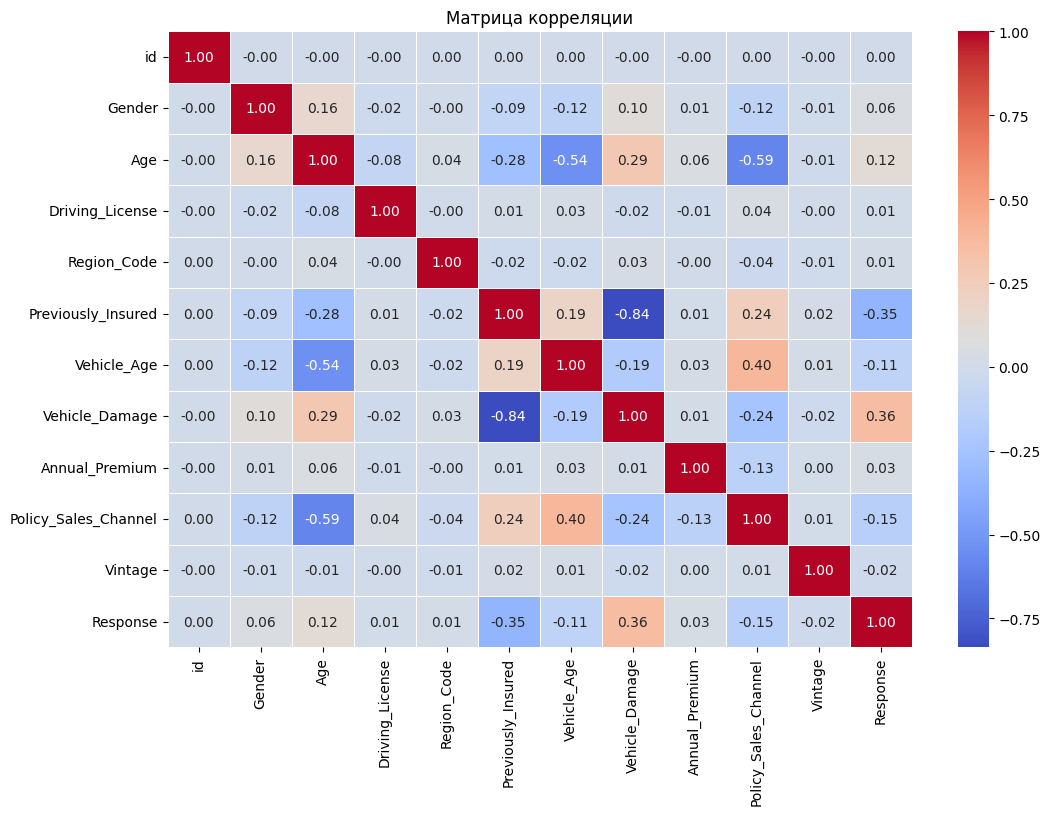

In [5]:
categorical_columns = train_data.select_dtypes(include=['object']).columns
encoder = LabelEncoder()

for col in categorical_columns:
    train_data[col] = encoder.fit_transform(train_data[col])

numeric_data = train_data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

Теперь заметно, что `Response` коррелирует также с ущербом оборудования(машины) и, менее, с возрастом человека.

### Предварительная обработка данных

Для начала закодируем обычным one-hot кодированием категориальные переменные:

In [6]:
train_data = pd.get_dummies(train_data, drop_first=True)

Теперь сформируем датасеты для обучения и тестирования. Предварительно, оставим для обучения только те данные, которые по результатам EDA влияют больше всего, а остальные удалим. Естественно, удалим также и `Response`.

In [7]:
X = train_data.drop(columns=['Response', 'id', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Policy_Sales_Channel', 'Vintage'])
y = train_data['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Параметр `stratify` необходим для равномерного распределения наших двух классов по тренировочной и валидационной выборке, так как классы несбалансированны.

Взвесим классы и учтем это при построении и обучении модели. Формула для параметра `scale_pos_weight` взята из официальной документации XGBoost

In [8]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

Найдем веса классов для CatBoost, так как для этой модели нет параметра `scale_pos_weight` мы зададим веса классов несколько иначе:

In [9]:
class_counts = np.bincount(y_train)  
total_count = len(y_train)

class_weights = {i: total_count / (len(class_counts) * count) for i, count in enumerate(class_counts)}

### Построение Logistic Regression

Построим логистическую регрессию

In [10]:
logreg = LogisticRegression(class_weight = "balanced", max_iter = 1000)
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [11]:
y_pred = logreg.predict(X_test)

Оценим получившуюся модель:

In [12]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on the validation set: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy on the validation set: 0.62
              precision    recall  f1-score   support

           0       1.00      0.56      0.72   2017948
           1       0.24      0.98      0.39    283012

    accuracy                           0.62   2300960
   macro avg       0.62      0.77      0.55   2300960
weighted avg       0.90      0.62      0.68   2300960



И посмотрим на матрицу ошибок:

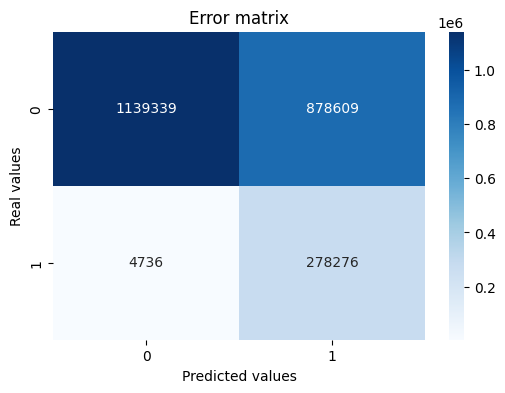

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Error matrix')
plt.ylabel('Real values')
plt.xlabel('Predicted values')
plt.show()

Как видно из матрицы, диагональ прослеживается, но она не явно выраженная, что говорит о не лучшей обученности модели. Тому могут быть несколько причин: 
1. Неправильная балансировка встроенной библиотеки
2. Невозможность разделить данные логистической регрессией. У метода есть свои ограничения, что не позволит достаточно обучить модель при определенном наборе данных (что мы и видели выше)

Так как у нас бинарный классификатор, построим ROC-кривую:

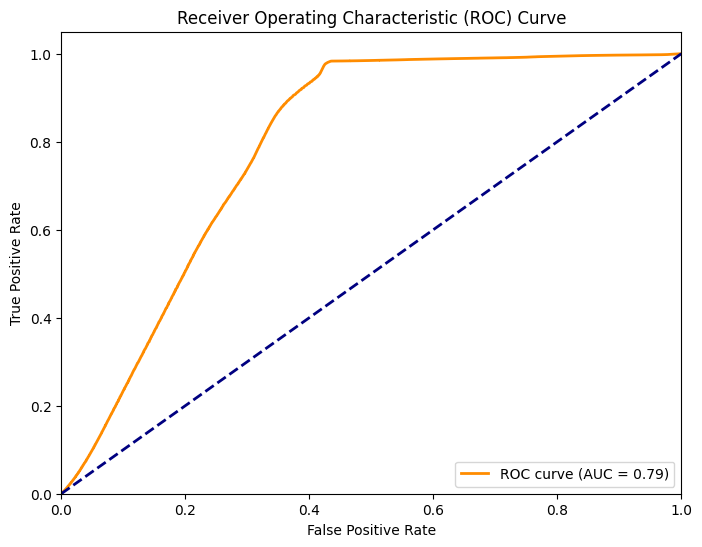

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob = logreg.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Построение и оценка модели XGBoost

Инициализируем модель XGBoost, в конструктор передадим параметр сдвига по весам:

In [15]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)

Наконец, обучим нашу модель:

In [16]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Теперь самое время оценить результаты. Для этого сначала посчитаем численно AUC-ROC Score и выведем краткий отчет о классификации, включающем в себя recall, precision и f1-score.

In [17]:
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))

AUC-ROC Score: 0.842200271810684
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.66      0.79   2017948
           1       0.27      0.92      0.42    283012

    accuracy                           0.69   2300960
   macro avg       0.63      0.79      0.60   2300960
weighted avg       0.90      0.69      0.74   2300960



 Модель обучилась достаточно, о чем свидетельствует высокий AUC-ROC (0.84) и f1-score (0.7 в среднем). Для лучшей визуализации построим матрицу ошибок:

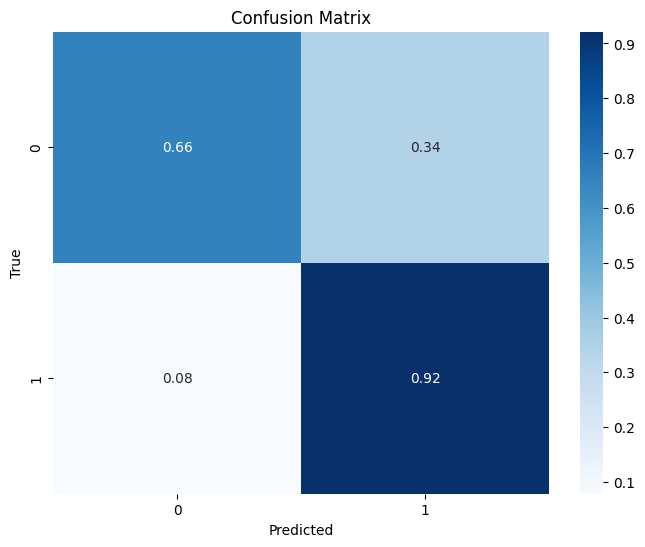

In [18]:
y_pred = xgb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Отчетливо выделяется диагональ - это свидетельствует о том, что классификатор справляется со своей задачей определять решение клиента.

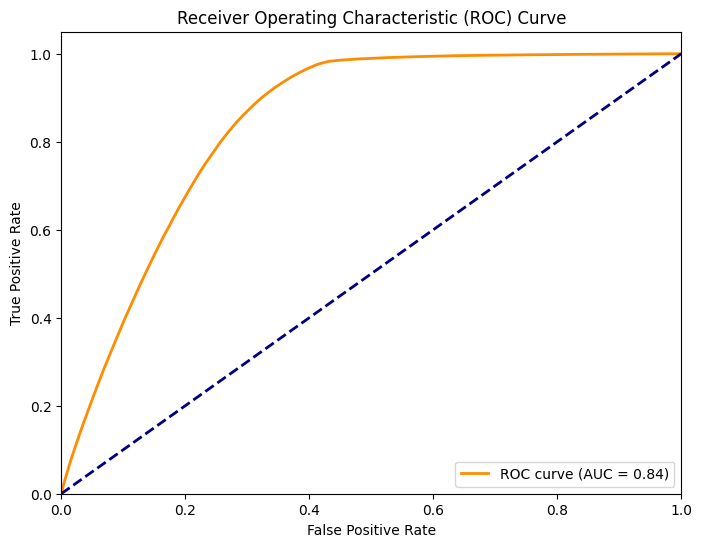

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob = xgb.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Удалось обучить хороший работоспособный классификатор. Посмотрим на анализ важности признаков - какие переменные вносят наибольшее влияние при предсказаниях. В контексте XGBoost - сколько раз признак был использован для разделений в деревьях. Для этого воспользуемся функцией `plot_importance`, поставляемой из коробки вместе с самим бустингом.

<Figure size 1000x800 with 0 Axes>

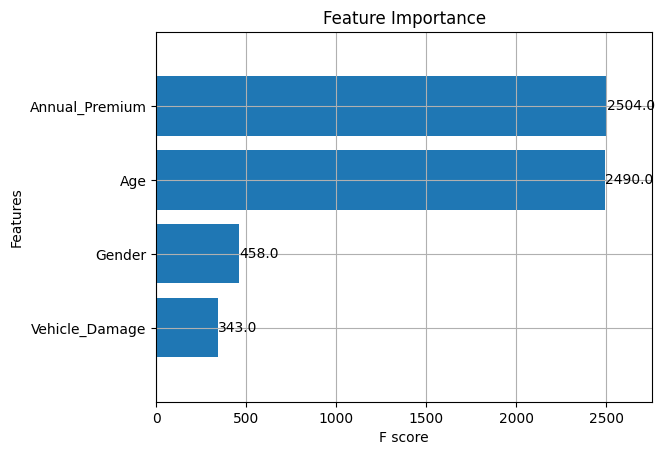

In [20]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(xgb, importance_type='weight', height=0.8)
plt.title('Feature Importance')
plt.show()

Больше всего влияет выплаты, хотя до этого нельзя было сделать подобного вывода. Здесь есть рациональное объяснение: при страховании человек хочет получить наибольшую компенсацию и денежный фактор замотивирует больше всего. Также, как и возраст, потому что старение человека делает его более рациональным и продуманным

### Построение CatBoost

Создадим и обучим модель:

In [21]:
catb = CatBoostClassifier(iterations=300, depth=3, learning_rate=0.1, loss_function='Logloss', verbose=0, class_weights=class_weights)

In [22]:
catb.fit(X_train, y_train, verbose = 0)

Оценим получившийся результат:

Accuracy: 0.6893457513385717
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79   2017948
           1       0.27      0.92      0.42    283012

    accuracy                           0.69   2300960
   macro avg       0.63      0.79      0.60   2300960
weighted avg       0.90      0.69      0.74   2300960



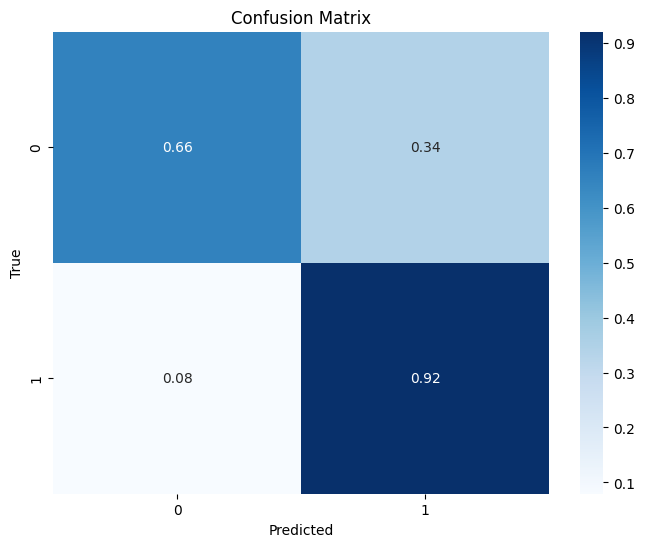

In [23]:
y_pred = catb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division = 0)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(class_report)
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Видим диагональ, модель обучился хорошо. Ну и построим ROC-кривую:

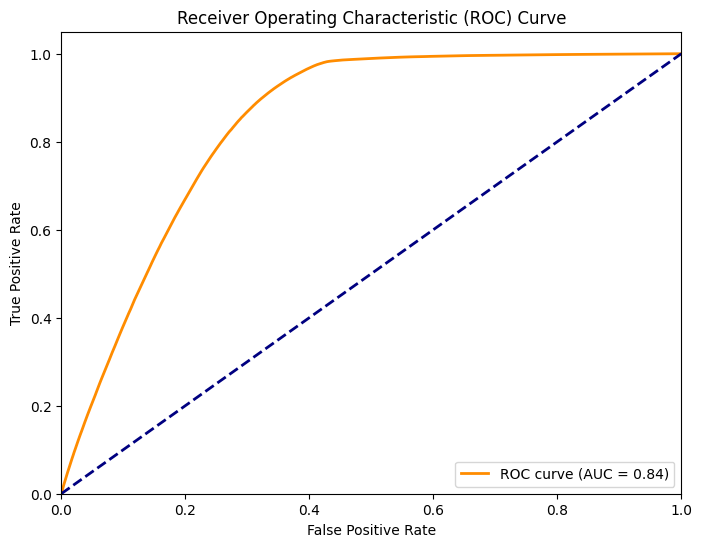

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob = catb.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Улучшение результатов с помощью стекинга моделей 

Сгенерируем мета-признаки:

In [25]:
logreg_preds = logreg.predict_proba(X_train)[:, 1]
xgb_preds = xgb.predict_proba(X_train)[:, 1]
catb_preds = catb.predict_proba(X_train)[:, 1]

Объединим в новое мета-представление:

In [26]:
meta_X_train = np.column_stack((logreg_preds, xgb_preds, catb_preds))

И предскажем новые результаты:

In [27]:
logreg_preds_test = logreg.predict_proba(X_test)[:, 1]
xgb_preds_test = xgb.predict_proba(X_test)[:, 1]
catb_preds_test = catb.predict_proba(X_test)[:, 1]

meta_X_test = np.column_stack((logreg_preds_test, xgb_preds_test, catb_preds_test))

Теперь возьмем новую мета-модель и обучим её (например, с помощью XGBoost):

In [28]:
meta_model = XGBClassifier(scale_pos_weight=scale_pos_weight)
meta_model.fit(meta_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Оценим результаты:

In [29]:
y_pred = meta_model.predict(meta_X_test)
y_pred_proba = meta_model.predict_proba(meta_X_test)[:, 1]

print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))

AUC-ROC Score: 0.842202203178643
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.66      0.79   2017948
           1       0.27      0.92      0.42    283012

    accuracy                           0.69   2300960
   macro avg       0.63      0.79      0.61   2300960
weighted avg       0.90      0.69      0.74   2300960



Посмотрим на матрицу ошибок:

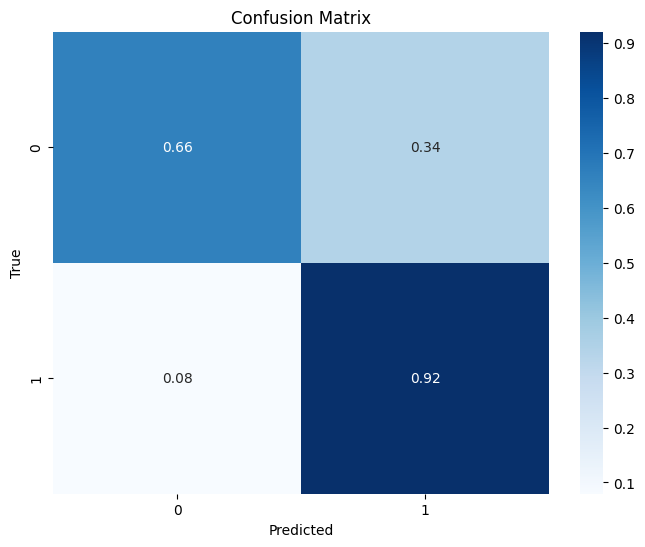

In [30]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Как видно, мета модель справяется тоже неплохо, предсказания получаются достаточно точные. 